Dataset:[Covert and Overt ERP-based BCI](https://lampx.tugraz.at/~bci/database/009-2014/description.pdf)<br>
Paper: [Influence of P300 latency jitter on event related potential-based brain–computer interface performance](https://iopscience.iop.org/article/10.1088/1741-2560/11/3/035008/pdf)

# Import

In [3]:
from google.colab import drive

import scipy.io
import os
import math
from scipy import stats

from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statistics import mean
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
# for training the model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import CCA

import torch.nn as nn
import torch.optim as optim
import torch

In [5]:
import tensorflow_probability as tfp
dist = tfp.distributions

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# please create a shortcut of EEG Speller folder in the home page of drive before running this cell
%cd '/content/drive/MyDrive/EEG Speller'

/content/drive/MyDrive/EEG Speller


# Constants

In [8]:
recording_freq = 256
timepoint_to_ms = 1 / recording_freq * 1000
epoch_length = 800
ms_to_timepoint = 1 / timepoint_to_ms
channels = ['Fz', 'Cz', 'Pz', 'Oz', 'P3', 'P4', 'PO7', 'PO8', 'F3', 'F4',
        'FCz', 'C3', 'C4', 'CP3', 'CPz', 'CP4']
meta = {
  'recording_freq':recording_freq, # unit: Hz
  'inter_stimulus_duration':32, # unit: timepoint
  'stimulus_duration':32, # unit: timepoint
  'stimulation_num':8,
  'timepoint_to_ms':timepoint_to_ms, # equals 3.90625 ms/timepoint
  'ms_to_timepoint':ms_to_timepoint, # equals 0.256 timepoint/ms
  'run_num':3,
  'trial_num':6,
  'target_num':2,
  'inter_trial_interval': 512, # unit: timepoint 
  'non_target_num':10,
  'stimuli_num': 36, # 6 by 6 grdi speller
  'channel_num':len(channels),
  'epoch_length': epoch_length, # unit: ms
  'epoch_length_timepoint':int(epoch_length * ms_to_timepoint), # unit: timepoint
  'labels':{"idle": 0, "non-target": 1, "target": 2},
  'trials':[1544, 9736, 17928, 26120, 34312, 42504],
  'channels':channels, # the exact same order as X
  'subjects_num':10,
  'soa': 64 # unit: timepoint
}

## Set seed

In [9]:
RANDOM_SEED = 2021
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED) 

# Use the GPU provided by Google Colab if run time is GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Helper Functions

In [10]:
def get_dict_from_data(patient_data):
  # Params:
  #   patient_data: the unprocessed individual patient data (i.e. already indexed)
  # Return:
  #   dictionary consisting of:
  #   X: (run, timepoints, channels)
  #   y: (run, timepoints * stimulations * (target))
  #   y_stim (run, timepoints, 13)
  #   channels: 1d-array
  #   trial: 1d-array
  #   fs: int

  data = patient_data['data']
  # removing redundent dimension
  data = data[0][:]
  filtered_data = [] # (run, None), second dimension is not fixed
  for i, run in enumerate(data):
    filtered_data.append(run[0][0])

  X_stack = [] 
  y_stack = []  
  y_stim_stack = []
  for i, run in enumerate(filtered_data):
    channels = np.concatenate(run[0][0])
    X = run[1]
    y = np.squeeze(run[2])
    y_stim = np.squeeze(run[3])
    trial = np.squeeze(run[4]) - 1 # the trial is shifted by one for some reason
    fs = np.squeeze(run[5])
    X_stack.append(X)
    y_stack.append(y)
    y_stim_stack.append(y_stim)
  X_stack = np.stack(X_stack, axis=0) 
  y_stack = np.stack(y_stack, axis=0)
  y_stim_stack = np.stack(y_stim_stack, axis=0)
  return dict(channels=channels, X=X_stack, y=y_stack, y_stim=y_stim_stack, trial=trial, fs=fs)

In [11]:
def get_epoch_data(patient_dict, meta):
  # Params:
  #   patient_dict: dictionary of the patient data
  #   meta: meta data of the recording
  #
  # Return:
  #   epoched_potential: (run_num, trial_num, stimulation_num, (target_num + non_target_num), epoch_length_timepoint, channel_num)
  #   epoched_label: (run_num, trial_num, stimulation_num, (target_num + non_target_num))

  epoch_length_timepoint = meta['epoch_length_timepoint']
  channel_num = meta['channel_num']
  run_num = meta['run_num']
  trial_num = len(meta['trials'])
  stimulation_num = meta['stimulation_num']
  target_num = meta['target_num']
  non_target_num = meta['non_target_num']
  trials = meta['trials']
  labels = meta['labels']
  stimulus_duration = meta['stimulus_duration']
  inter_stimulus_duration = meta['inter_stimulus_duration']

  epoched_potential = np.zeros([run_num, trial_num, stimulation_num, target_num + non_target_num, epoch_length_timepoint, channel_num])
  epoched_label = np.zeros([run_num, trial_num, stimulation_num, target_num + non_target_num])
  epoched_label_stim = np.zeros([run_num, trial_num, stimulation_num, target_num + non_target_num])

  count = 0
  for i in range(run_num):
    for j, trial in enumerate(trials):
      counter = trial
      for k in range(stimulation_num):
        for l in range(target_num + non_target_num):
          label = patient_dict['y'][i][counter]
          label_stim = patient_dict['y_stim'][i][counter]
          data = patient_dict['X'][i][counter: counter + epoch_length_timepoint, :]
          epoched_potential[i, j, k, l, :, :] = data
          if label == labels["target"]:
            epoched_label[i, j, k, l] = meta['labels']['target']
            count += 1
          elif label == labels["non-target"]:
            epoched_label[i, j, k, l] = meta['labels']['non-target']
            count += 1
          epoched_label_stim[i, j, k, l] = label_stim
          counter += stimulus_duration + inter_stimulus_duration
  assert (count == run_num * trial_num * stimulation_num * (target_num + non_target_num)), "epoch label mismatch! please inspect the epoch labels"
  
  # re-aligned stimulations such that all stimulations can be ordered the same
  mask = epoched_label_stim - 1 # make zero-based
  for i in range(run_num):
    for j in range(trial_num):
      rows = np.repeat(np.arange(len(epoched_label[i, j]))[:, None], epoched_label[i, j].shape[1], axis=1)
      columns = mask[i, j].astype(np.int).argsort()
      epoched_label[i, j] = epoched_label[i, j][rows, columns]
      epoched_potential[i, j] = epoched_potential[i, j, rows, columns, :, :]

  # reshape to desired
  return epoched_potential, epoched_label

In [12]:
def get_ece(pred, label):
  '''
  Given predictions of the model, return the binned confidence, predictions, and ece.
  If a particular bin has cardinality = 0, assign it np.nan
  Args:
    pred: (num_samples, num_classes)
  Return:
    binned_conf (num_bin):
    binned_prob (num_bin):
    ece (int):
  '''
  confidence_list = [[0, .1], [.1, .2], [.2, .3], [.3, .4], [.4, .5], [.5, .6], [.6, .7], [.7, .8], [.8, .9], [.9, 1]]
  accuracies = np.empty(len(confidence_list))
  avg_confidences = np.empty(len(confidence_list))
  ece = 0
  # Runs to for 10 bins in the specified confidence ranges
  for j, conf_range in enumerate(confidence_list):
    bin = []
    index_list = []
    # For each prediction check if within range of confidences on 1st column
    for i in range(0, len(pred)):
      if pred[i][0] < conf_range[1] and pred[i][0] > conf_range[0]:
        bin.append(pred[i, 0].tolist())
        index_list.append(i)
    # Doesn't add when no values within confidence range
    if len(bin) == 0:
      avg_confidences[j] = np.nan
      accuracies[j] = np.nan
      continue
    confidence_bin = np.array(bin).mean()
    accuracy_bin = accuracy_score(y_true=label[index_list].argmax(axis=1), y_pred=np.zeros(len(bin)))
    avg_confidences[j] = confidence_bin
    accuracies[j] = accuracy_bin
    ece += len(bin) / len(pred) * np.abs(accuracy_bin - confidence_bin)
  return avg_confidences, accuracies, ece

In [13]:
def generate_class_weights(y, n_classes):
  '''
  Args: 
    y (int array): (n_samples,) from 0, ..., n_classes
  '''
  weights = len(y) / (n_classes * np.bincount(y))
  class_weights = {}
  for i in range(n_classes):
    class_weights[i] = weights[i]
  return class_weights

In [14]:
def calculateITR(accuracy, soa, num_sequence, inter_trial_interval, num_stimuli):
  '''
  Args:
    accuracy (int):
    soa (int):
    num_sequences (int):
    inter_trial_interal (int):
    num_stimuli (int):
  '''
  B = math.log(num_stimuli, 2) + accuracy * math.log(accuracy, 2) + ((1-accuracy) * math.log((1-accuracy)/(num_stimuli - 1), 2))
  T = ((soa * num_sequence * 12) + inter_trial_interval) / 60
  return B/T

# Description of the dataset P300
* 3 runs per session, 6 trials (i.e. character) per run, 8 simulations per trial, 12 classes (10 non-targets + 2 targets). 
* 16 channels, 10-10 montage
* y (0:non-target, 1:target)
* y_stim (0: idle, 1: class1, 2: class2, ... 12: class12)
* 256 Hz, 3.90625 ms/timepoint

## Load all patient data

In [15]:
data_path = "data/Covert and overt ERP-based BCI (009-2014)/P300 Speller"
patient_data = [scipy.io.loadmat(os.path.join(data_path, file)) for file in os.listdir(data_path)]

## Take a look at AO1S

In [16]:
patient_1 = get_dict_from_data(patient_data[0])

Epoch the data

In [17]:
X, y = get_epoch_data(patient_1, meta)
X_all_stims = X.reshape([-1, X.shape[-2], X.shape[-1]])
y_all_stims = y.reshape([-1])
target_avg_potential = X_all_stims[y_all_stims == meta['labels']['target'], :, :].mean(axis=0)
non_target_avg_potential = X_all_stims[y_all_stims == meta['labels']['non-target'], :, :].mean(axis=0)

Averaged P300 potential waveforms at the Cz electrode position obtained from a representative subject using the P300
interfaces. <br>
Note: overlapping epochs

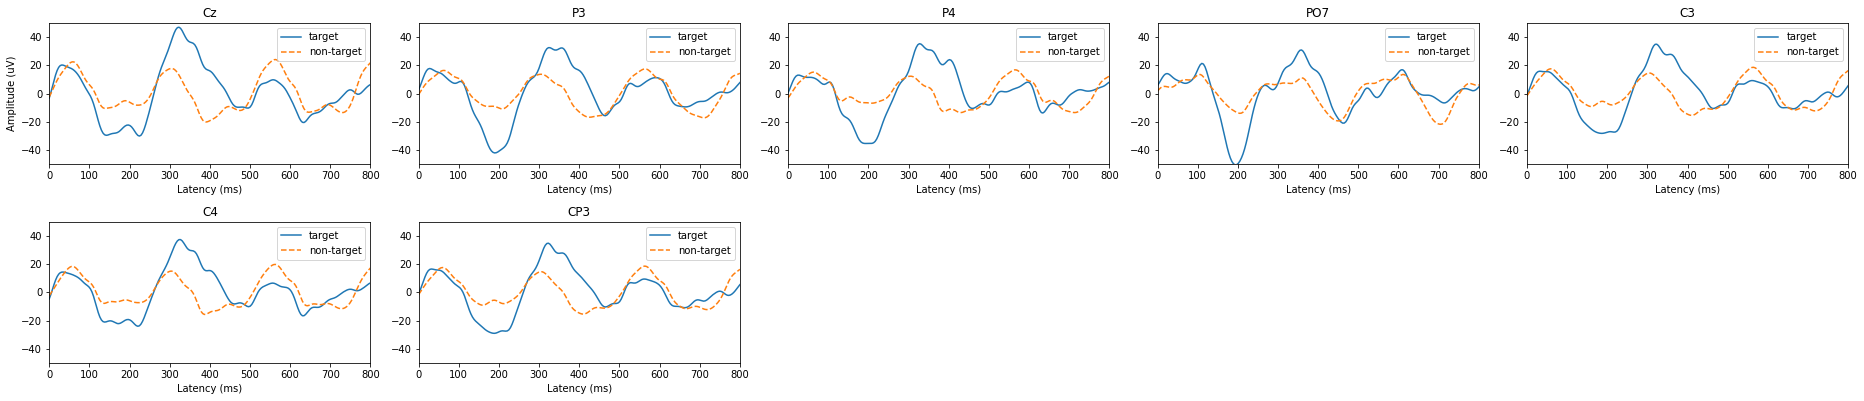

In [18]:
ncols = 5
nrows = 3
xmin, xmax = 0, epoch_length
ymin, ymax = -50, 50
plt.figure(figsize=(26, 8))
channels_to_try = ['Cz', 'P3', 'P4', 'PO7', 'C3', 'C4', 'CP3']

for i, channel in enumerate(channels_to_try):
  plt.subplot(nrows, ncols, i + 1)
  channel_idx = meta['channels'].index(channel)
  xticks = np.linspace(0, meta['epoch_length'], meta['epoch_length_timepoint'])
  ax = sns.lineplot(x=xticks, y=target_avg_potential[:, channel_idx], label='target')
  ax.set_title(channel)
  ax.set_xlim(xmin, xmax)
  ax.set_ylim(ymin, ymax)
  if i % len(channels_to_try) == 0:
    ax.set_ylabel('Amplitude (uV)')
  ax.set_xlabel('Latency (ms)')
  sns.lineplot(x=xticks, y=non_target_avg_potential[:, channel_idx], label='non-target', linestyle='--')
  ax.legend(loc='upper right')
plt.tight_layout()

# Modeling

## EEGNet

In [19]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))
    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

#### Preprocessing
X has to be the shape (epochs, channels, timepoints, 1) <br>
y has to be the shape (epochs, class_num)

In [20]:
class EEGNetData():
  def __init__(self, X, y):
    '''
    Args:
      X: (run_num, trmial_nu, stimulation_num, (target_num + non_target_num), epoch_length_timepoint, channel_num)
      y: (run_num, trial_num, stimulation_num, (target_num + non_target_num))
    Return:
      self.X: (run_num * trial_num * (target_num + non_target_num), channel_num, epoch_length_timepoint, 1)
      self.y: (run_num * trial_num * (target_num + non_target_num), target_num + non_target_num)
    '''
    # average the stimlulations 
    X = X.mean(axis=2)
    # reshape to required dimension
    X = X.reshape([-1, X.shape[-2], X.shape[-1]])
    X = X.transpose([0, 2, 1])
    X = X[:, :, :, None]
    y = y[:, :, 0, :] # since all y labels have been align stimulation-wise
    y = y.reshape([-1])
    # readjust the labels of y to (0, 1, 0, 1, ... , num_classes), 0: non-target, 1: target (originally was 1: non-target and 2: target)
    y = np.where(y == 1, 0, 1)
    y = to_categorical(y, num_classes=2) # binary classification
    self.X = X
    self.y = y

In [21]:
class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self, X_test, y_test, epochs, monte_carlo):
    '''
    Args:
      monte_carlo (list): number of monte carlos to run
    '''
    self.epochs = epochs
    self.X_test = X_test
    self.y_test = y_test
    self.monte_carlo = monte_carlo
    self.acc = np.zeros(epochs, len(monte_carlo))
  def on_epoch_end(self, epoch, logs=None):
    for i in range(len(self.monte_carlo)):
      probs = np.zeros([self.monte_carlo[i]] + list(self.y_test.shape))
      for j in range(self.monte_carlo[i]):
        probs[j] = self.model.predict(self.X_test)
      probs = probs.mean(axis=0)
      self.acc[epoch, i] = accuracy_score(probs.argmax(axis=1), self.y_test.argmax(axis=1))

In [22]:
def get_eegnet_acc(epochs, subject, meta, verbose=0, temperature_cal=False):
  '''
  Args:
    epochs (int): 
    subject (int): idx of the subject
  Return:
    test_acc (array): (run_num, epochs) trained with all stimulations. contains monte_carlo=1 automatically
    train_acc (array): (run_num, epochs) trained with all stimulations
    stim_acc (array): (num_stim, run_num) obtained by doing cross validation
    monte_carlo (list): number of monte carlos to run, must not be empty
  '''
  train_acc = np.zeros([meta['run_num'], epochs])
  test_acc = np.zeros([meta['run_num'], epochs])
  stim_acc = np.zeros([meta['stimulation_num'], meta['run_num']])
  conf_bins = np.zeros([meta['run_num'], meta['stimulation_num'], 10]) # we're using 10 bins for ece
  acc_bins = np.zeros([meta['run_num'], meta['stimulation_num'], 10]) # we're using 10 bins for ece
  ece_subject = np.zeros([meta['run_num'], meta['stimulation_num']]) 
 

  kf = KFold(n_splits=meta['run_num'])
  patient = get_dict_from_data(patient_data[subject])
  # split data into train, test, and validation sets
  X, y = get_epoch_data(patient, meta)
  # use one of the three runs as test set
  for i, (train_index, test_index) in enumerate(kf.split(X)):
    if verbose >= 1:
      run_num = meta['run_num']
      print(f'Fold {i + 1} / {run_num}')
    X_train_orig, y_train_orig = X[train_index], y[train_index]
    X_test_orig, y_test_orig = X[test_index], y[test_index]
    
    train_data = EEGNetData(X_train_orig, y_train_orig)
    X_train, y_train = train_data.X, train_data.y
    test_data = EEGNetData(X_test_orig, y_test_orig)
    X_test, y_test = test_data.X, test_data.y

    # build the model
    model = EEGNet(nb_classes = 2, Chans = len(channels), 
                  Samples = meta['epoch_length_timepoint'], 
                  dropoutRate = 0.5)
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics = ['acc'])


    # train the model
    class_weights = generate_class_weights(y_train.argmax(axis=1), 2)
    history = model.fit(X_train, y_train, batch_size = 16, epochs = epochs, 
                          verbose = 0, validation_data=(X_test, y_test), 
                          class_weight = class_weights)
    
    train_acc[i] = history.history['acc']
    test_acc[i] = history.history['val_acc']

    for j in range(1, meta['stimulation_num'] + 1):
      test_data = EEGNetData(X_test_orig[:, :, np.arange(0, j), :, :, :], y_test_orig)  
      X_test, y_test = test_data.X, test_data.y
      verbosity = 1 if verbose >= 2 else 0
      stim_acc[j - 1, i] = model.evaluate(X_test, y_test, verbose=verbosity)[1]

      # temperature scaling 
      temperature = 0.15 # obtained by gradient descent
      temperature = temperature if temperature_cal else 1
      # Create a intermediate model that doens't go through softmax
      temp_model = Model(inputs=model.input, outputs=model.get_layer('dense').output)
      logits = temp_model.predict(X_test) / temperature
      confs = tf.nn.softmax(logits).numpy()
      confs, accs, ece =  get_ece(confs, y_test)
      conf_bins[i, j - 1] = confs
      acc_bins[i, j - 1] = accs
      ece_subject[i, j - 1] = ece
  return dict(train_acc=train_acc, test_acc=test_acc, stim_acc=stim_acc, conf_bins=conf_bins, acc_bins=acc_bins, ece_subject=ece_subject)

#### Look at one subject

In [23]:
subject = 0
epochs = 40
eegnet_output = get_eegnet_acc(epochs, subject, meta, verbose=1)

Fold 1 / 3
Fold 2 / 3
Fold 3 / 3


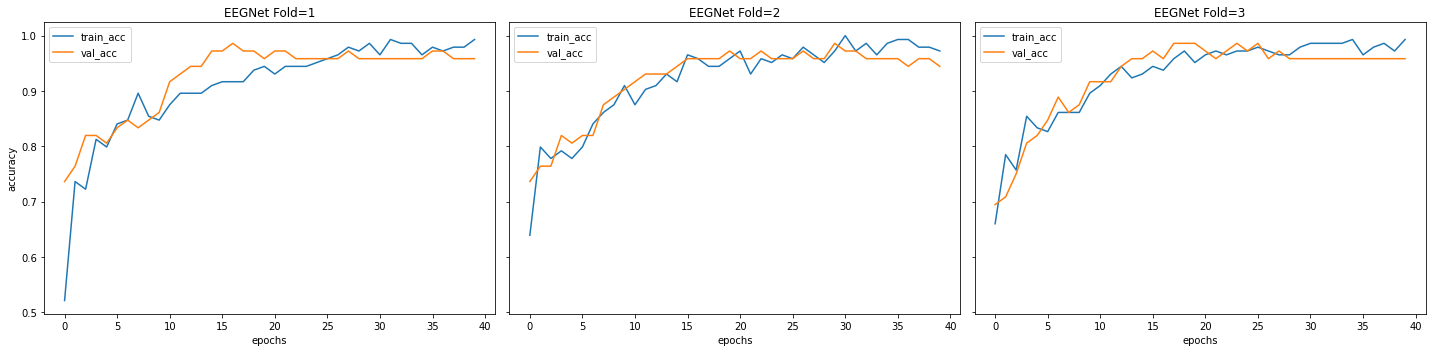

In [24]:
fig, axes = plt.subplots(ncols=meta['run_num'], nrows=1, figsize=(20, 5), sharey=True)
xticks = list(range(epochs))
for i in range(meta['run_num']):
  sns.lineplot(x=xticks, y=eegnet_output['train_acc'][i], label='train_acc', ax=axes[i])
  axes[i].set_xlabel('epochs')
  axes[i].set_ylabel('accuracy')
  axes[i].set_title(f'EEGNet Fold={i + 1}')
  sns.lineplot(x=xticks, y=eegnet_output['test_acc'][i], label='val_acc', ax=axes[i]);
plt.tight_layout()

#### Accuracy Calibraiton with Temperature

##### Without temperature

In [28]:
grand_confs = np.zeros([meta['subjects_num'], meta['stimulation_num'], 10]) # we're using 10 bins for ece
grand_accs = np.zeros([meta['subjects_num'], meta['stimulation_num'], 10])
grand_ece = np.zeros([meta['subjects_num'], meta['stimulation_num']])
for i in tqdm(range(meta['subjects_num'])):
  output = get_eegnet_acc(epochs, i, meta, verbose=0, temperature_cal=False)
  # average across validations
  confs = np.nanmean(output['conf_bins'], axis=0)
  accs = np.nanmean(output['acc_bins'], axis=0)
  ece = output['ece_subject'].mean(axis=0)

  grand_confs[i] = confs
  grand_accs[i] = accs
  grand_ece[i] = ece

100%|██████████| 10/10 [03:29<00:00, 20.96s/it]


##### With temperature

In [37]:
temp_grand_confs = np.zeros([meta['subjects_num'], meta['stimulation_num'], 10]) # we're using 10 bins for ece
temp_grand_accs = np.zeros([meta['subjects_num'], meta['stimulation_num'], 10])
temp_grand_ece = np.zeros([meta['subjects_num'], meta['stimulation_num']])
for i in tqdm(range(meta['subjects_num'])):
  output = get_eegnet_acc(epochs, i, meta, verbose=0, temperature_cal=True)
  # average across validations
  confs = np.nanmean(output['conf_bins'], axis=0)
  accs = np.nanmean(output['acc_bins'], axis=0)
  ece = output['ece_subject'].mean(axis=0)
  temp_grand_confs[i] = confs
  temp_grand_accs[i] = accs
  temp_grand_ece[i] = ece

100%|██████████| 10/10 [03:28<00:00, 20.88s/it]


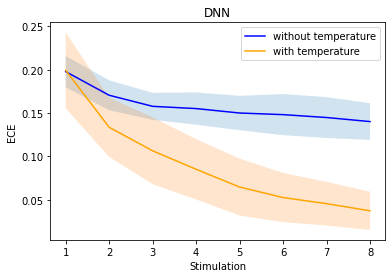

In [39]:
xticks = np.arange(1, meta['stimulation_num'] + 1)
mean = np.nanmean(grand_ece, axis=0)
std = np.nanstd(grand_ece, axis=0)
ax = sns.lineplot(x=xticks, y=mean, color='blue', label='without temperature')
ax.fill_between(xticks, mean - std, mean + std, alpha=0.2)

mean = np.nanmean(temp_grand_ece, axis=0)
std = np.nanstd(temp_grand_ece, axis=0)
ax = sns.lineplot(x=xticks, y=np.nanmean(temp_grand_ece, axis=0), color='orange', label='with temperature')
ax.fill_between(xticks, mean - std, mean + std, alpha=0.2)

plt.title('DNN')
plt.xlabel('Stimulation')
plt.ylabel('ECE');

## EEGNet with Bayesian

In [40]:
class BayesNet(tf.keras.Model):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """
    def __init__(self, nb_classes, num_training, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
      super(BayesNet, self).__init__()
      self.kl_divergence_function = lambda q, p, _: dist.kl_divergence(q, p) / tf.cast(num_training, dtype=tf.float32)
      self.nb_classes = nb_classes
      self.num_training = num_training
      self.Chans = Chans
      self.Samples = Samples
      self.dropoutRate = dropoutRate
      self.kernLength = kernLength
      self.F1 = F1
      self.D = D
      self.F2 = F2
      self.norm_rate = norm_rate
      # whether to return the normalized logits
      self.softmax_on = True
      # layers
      if dropoutType == 'SpatialDropout2D':
          self.dropoutType = SpatialDropout2D
      elif dropoutType == 'Dropout':
          self.dropoutType = Dropout
      else:
          raise ValueError('dropoutType must be one of SpatialDropout2D '
                          'or Dropout, passed as a string.')
      self.conv1 = Conv2D(self.F1, (1, self.kernLength), padding = 'same',
                                    input_shape = (self.Chans, self.Samples, 1),
                                    use_bias = False)
      self.b1A = BatchNormalization()
      self.dconv1 = DepthwiseConv2D((self.Chans, 1), use_bias = False, 
                                    depth_multiplier = self.D,
                                    depthwise_constraint = max_norm(1.))
      self.b1B = BatchNormalization()
      self.a1 = Activation('elu')
      self.avg1 = AveragePooling2D((1, 4))
      self.d1 = self.dropoutType(self.dropoutRate)

      self.sconv2 = SeparableConv2D(self.F2, (1, 16),
                                    use_bias = False, padding = 'same')
      self.b2 = BatchNormalization()
      self.a2 = Activation('elu')
      self.avg2 = AveragePooling2D((1, 8))
      self.d2 = self.dropoutType(self.dropoutRate)

      self.f = Flatten(name = 'flatten')
      self.classifier = tfp.layers.DenseFlipout(self.nb_classes, name = 'dense', kernel_divergence_fn=self.kl_divergence_function)
      self.a3 = Activation('softmax', name = 'softmax')
    def call(self, inputs):
      assert inputs.shape[1:] == (self.Chans, self.Samples, 1)
      ##################################################################
      block1       = self.conv1(inputs)
      block1       = self.b1A(block1)
      block1       = self.dconv1(block1)
      block1       = self.b1B(block1)
      block1       = self.a1(block1)
      block1       = self.avg1(block1)
      block1       = self.d1(block1)
      
      block2       = self.sconv2(block1)
      block2       = self.b2(block2)
      block2       = self.a2(block2)
      block2       = self.avg2(block2)
      block2       = self.d2(block2)
          
      flatten      = self.f(block2)
      dense        = self.classifier(flatten)
      softmax      = self.a3(dense)
      return softmax

In [43]:
def get_bayes_acc(epochs, subject, meta, monte_carlo=[1], verbose=0, temperature_cal=False):
  '''
  Args:
    epochs (int): 
    subject (int): idx of the subject
    monte_carlo (list)
  Return:
    test_acc (array): (run_num, epochs) trained with all stimulations
    train_acc (array): (run_num, epochs) trained with all stimulations
    d_stim_prob (array): (num_run, 3) 3 -> (max probability of class, stimulation_num, accuracy) 
  '''

  assert monte_carlo
  train_acc = np.zeros([meta['run_num'], epochs])
  test_acc = np.zeros([meta['run_num'], epochs])
  stim_acc = np.zeros([len(monte_carlo), meta['run_num'], meta['stimulation_num']])
  conf_bins = np.zeros([len(monte_carlo), meta['run_num'], meta['stimulation_num'], 10]) # we're using 10 bins for ece
  acc_bins = np.zeros([len(monte_carlo), meta['run_num'], meta['stimulation_num'], 10]) # we're using 10 bins for ece
  ece_subject = np.zeros([len(monte_carlo), meta['run_num'], meta['stimulation_num']]) 
  

  kf = KFold(n_splits=meta['run_num'])
  patient = get_dict_from_data(patient_data[subject])
  # split data into train, test, and validation sets
  X, y = get_epoch_data(patient, meta)
  # use one of the three runs as test set

  for i, (train_index, test_index) in enumerate(kf.split(X)):
    if verbose >= 1:
      run_num = meta['run_num']
      print(f'Fold {i + 1} / {run_num}')
    X_train_orig, y_train_orig = X[train_index], y[train_index]
    X_test_orig, y_test_orig = X[test_index], y[test_index]
    
    train_data = EEGNetData(X_train_orig, y_train_orig)
    X_train, y_train = train_data.X, train_data.y
    test_data = EEGNetData(X_test_orig, y_test_orig)
    X_test, y_test = test_data.X, test_data.y

    # build the model
    model = BayesNet(nb_classes = 2, num_training = len(y_train), Chans = len(channels), 
                    Samples = meta['epoch_length_timepoint'], 
                    dropoutRate = 0.5)
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics = ['acc'])
    # train the model
    class_weights = generate_class_weights(y_train.argmax(axis=1), 2)
    history = model.fit(X_train, y_train, batch_size = 16, epochs = epochs, 
                          verbose = 0, validation_data=(X_test, y_test), 
                          class_weight = class_weights)
    
    train_acc[i] = history.history['acc'] 
    test_acc[i] = history.history['val_acc']

    # use the max monte carlo
    for j in range(1, meta['stimulation_num'] + 1):
      test_data = EEGNetData(X_test_orig[:, :, np.arange(0, j), :, :, :], y_test_orig)  
      X_test, y_test = test_data.X, test_data.y
      for k in range(len(monte_carlo)):
        # verbosity = 1 if verbose >= 2 else 0
        avg_confs = np.mean([model.predict(X_test) for k in range(monte_carlo[k])], axis=0)
        stim_acc[k, i, j - 1] = accuracy_score(y_test.argmax(axis=1).astype(np.int), avg_confs.argmax(axis=1).astype(np.int))
        # for ECE graph
        confs, accs, ece =  get_ece(avg_confs, y_test)
        conf_bins[k, i, j - 1] = confs
        acc_bins[k, i, j - 1] = accs
        ece_subject[k, i, j - 1] = ece

  return dict(train_acc=train_acc, test_acc=test_acc, conf_bins=conf_bins, acc_bins=acc_bins, ece_subject=ece_subject, stim_acc=stim_acc)

#### Look at one subject

In [44]:
subject = 0
epochs = 40
output = get_bayes_acc(epochs, subject, meta, verbose=1, temperature_cal=False)

Fold 1 / 3
Fold 2 / 3
Fold 3 / 3


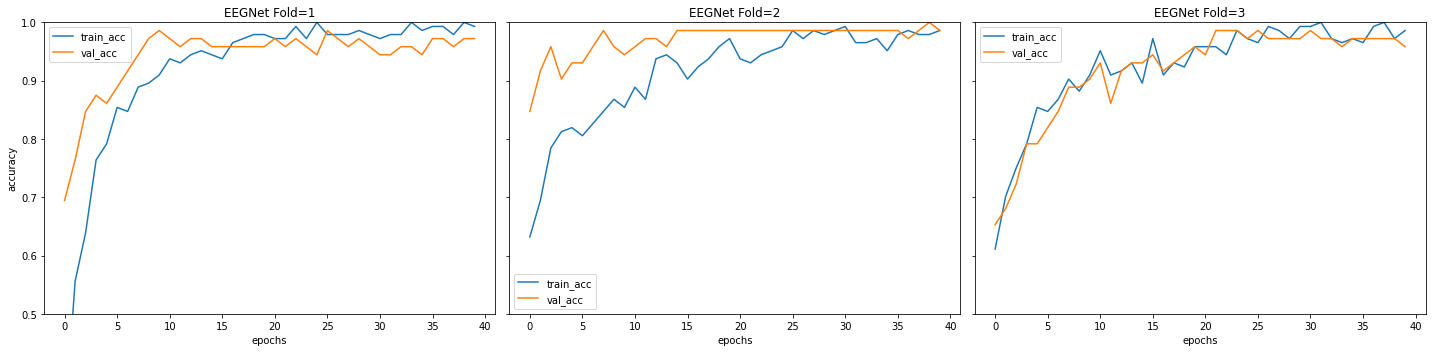

In [45]:
fig, axes = plt.subplots(ncols=meta['run_num'], nrows=1, figsize=(20, 5), sharey=True)
xticks = list(range(epochs))
for i in range(meta['run_num']):
  sns.lineplot(x=xticks, y=output['train_acc'][i], label='train_acc', ax=axes[i])
  axes[i].set_xlabel('epochs')
  axes[i].set_ylabel('accuracy')
  axes[i].set_title(f'EEGNet Fold={i + 1}')
  sns.lineplot(x=xticks, y=output['test_acc'][i], label='val_acc', ax=axes[i]);
plt.ylim([0.5, 1])
plt.tight_layout()

## Compare EEGNet and Bayesian across all subjects

In [48]:
epochs = 40
eegnet_train_acc = np.empty([meta['subjects_num'], epochs, meta['run_num']])
eegnet_test_acc = np.empty([meta['subjects_num'], epochs, meta['run_num']])
eegnet_stim_acc = np.empty([meta['subjects_num'], meta['stimulation_num'], meta['run_num']])
eegnet_ece = np.empty([meta['subjects_num'], meta['stimulation_num'], meta['run_num']])
for i in tqdm(range(meta['subjects_num'])):
  output = get_eegnet_acc(epochs, subject, meta, verbose=0)
  eegnet_train_acc[i] = output['train_acc'].T
  eegnet_test_acc[i] = output['test_acc'].T
  eegnet_stim_acc[i] = output['stim_acc']
  eegnet_ece[i] = output['ece_subject'].T
eegnet_train_acc = eegnet_train_acc.mean(axis=-1)
eegnet_test_acc = eegnet_test_acc.mean(axis=-1)
eegnet_stim_acc = eegnet_stim_acc.mean(axis=-1)
eegnet_ece = eegnet_ece.mean(axis=-1)

100%|██████████| 10/10 [03:33<00:00, 21.33s/it]


In [49]:
epochs = 40
monte_carlo=[5, 20, 50]
bayes_train_acc = np.empty([meta['subjects_num'], meta['run_num'], epochs])
bayes_test_acc = np.empty([meta['subjects_num'], meta['run_num'], epochs])
bayes_stim_acc = np.empty([meta['subjects_num'], len(monte_carlo), meta['run_num'], meta['stimulation_num']])
bayes_ece = np.empty([meta['subjects_num'], len(monte_carlo), meta['run_num'], meta['stimulation_num']])
for i in tqdm(range(meta['subjects_num'])):
  output = get_bayes_acc(epochs, subject, meta, monte_carlo=monte_carlo, verbose=0, temperature_cal=False)
  # the train and test acc here uses monte carlo = 1
  bayes_train_acc[i] = output['train_acc']
  bayes_test_acc[i] = output['test_acc']
  bayes_stim_acc[i] = output['stim_acc']
  bayes_ece[i] = output['ece_subject']
# avg out kfold
bayes_train_acc = bayes_train_acc.mean(axis=-2)
bayes_test_acc = bayes_test_acc.mean(axis=-2)
bayes_stim_acc = bayes_stim_acc.mean(axis=-2)
bayes_ece = bayes_ece.mean(axis=-2)

100%|██████████| 10/10 [18:37<00:00, 111.79s/it]


### Training curve  

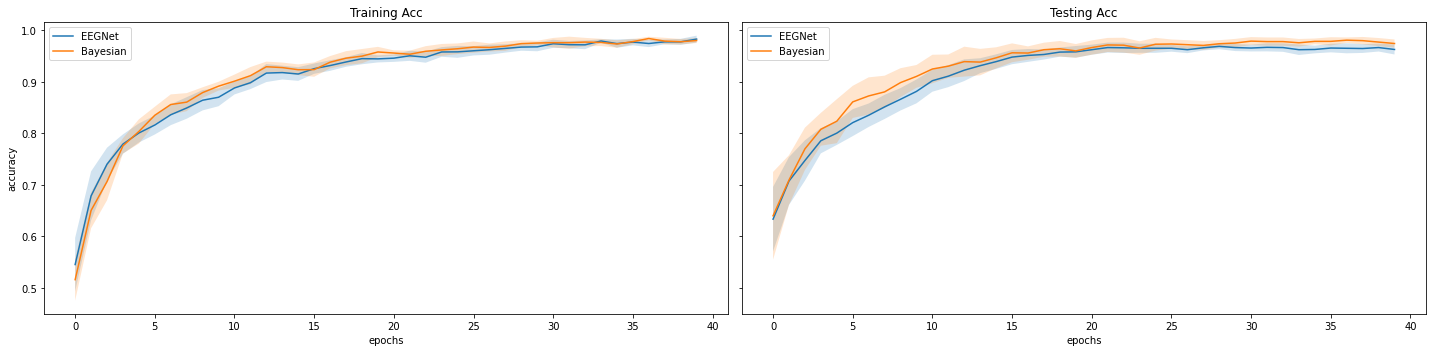

In [50]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 5), sharey=True)
xticks = list(range(epochs))
sns.lineplot(x=xticks, y=eegnet_train_acc.mean(axis=0), label='EEGNet', ax=axes[0])
axes[0].fill_between(np.arange(epochs), eegnet_train_acc.mean(axis=0) + eegnet_train_acc.std(axis=0), eegnet_train_acc.mean(axis=0) - eegnet_train_acc.std(axis=0), alpha=0.2)
sns.lineplot(x=xticks, y=bayes_train_acc.mean(axis=0), label='Bayesian', ax=axes[0])
axes[0].fill_between(np.arange(epochs), bayes_train_acc.mean(axis=0) + bayes_train_acc.std(axis=0), bayes_train_acc.mean(axis=0) - bayes_train_acc.std(axis=0), alpha=0.2)
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].set_title(f'Training Acc')

sns.lineplot(x=xticks, y=eegnet_test_acc.mean(axis=0), label='EEGNet', ax=axes[1])
axes[1].fill_between(np.arange(epochs), eegnet_test_acc.mean(axis=0) + eegnet_test_acc.std(axis=0), eegnet_test_acc.mean(axis=0) - eegnet_test_acc.std(axis=0), alpha=0.2)
sns.lineplot(x=xticks, y=bayes_test_acc.mean(axis=0), label='Bayesian', ax=axes[1])
axes[1].fill_between(np.arange(epochs), bayes_test_acc.mean(axis=0) + bayes_test_acc.std(axis=0), bayes_test_acc.mean(axis=0) - bayes_test_acc.std(axis=0), alpha=0.2)
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('accuracy')
axes[1].set_title(f'Testing Acc');
plt.tight_layout()

We see that monte_carlo = 5 for predictive distribution gets a decent accuracy, so we'll use that throughout the notebook

### Accuracy across stimulations

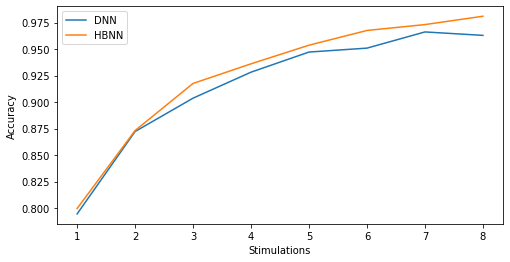

In [51]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 4), sharey=True)
xticks = np.arange(1, meta['stimulation_num'] + 1)
sns.lineplot(x=xticks, y=eegnet_stim_acc.mean(axis=0), label='DNN', ax=ax)
# ax.fill_between(xticks, eegnet_stim_acc.mean(axis=0) + eegnet_stim_acc.std(axis=0), eegnet_stim_acc.mean(axis=0) - eegnet_stim_acc.std(axis=0), alpha=0.2)
sns.lineplot(x=xticks, y=bayes_stim_acc[:, 0].mean(axis=0), label=f'HBNN', ax=ax)
# ax.fill_between(xticks, bayes_stim_acc[:, 0].mean(axis=0) + bayes_stim_acc[:, 0].std(axis=0), bayes_stim_acc[:, 0].mean(axis=0) - bayes_stim_acc[:, 0].std(axis=0), alpha=0.2)

ax.set_xlabel('Stimulations')
ax.set_ylabel('Accuracy');

In [52]:
# show this graph with +- std and up to floating 3 precision
df = pd.DataFrame(np.c_[eegnet_stim_acc.mean(axis=0), bayes_stim_acc[:, 0].mean(axis=0)], columns=['DNN', 'HBNN'])
df

,DNN,HBNN
0,0.794444,0.799537
1,0.872222,0.873148
2,0.903704,0.917593
3,0.928241,0.936111
4,0.947222,0.953704
5,0.950926,0.967593
6,0.966204,0.973148
7,0.962963,0.981019


#### ECE across stimulations

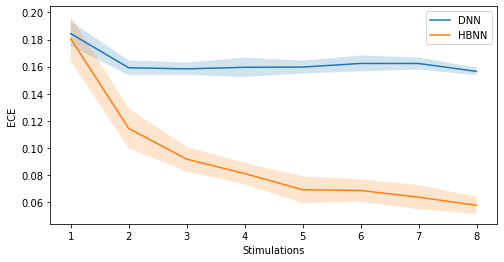

In [56]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 4), sharey=True)
xticks = np.arange(1, meta['stimulation_num'] + 1)
sns.lineplot(x=xticks, y=eegnet_ece.mean(axis=0), label='DNN', ax=ax)
ax.fill_between(xticks, eegnet_ece.mean(axis=0) + eegnet_ece.std(axis=0), eegnet_ece.mean(axis=0) - eegnet_ece.std(axis=0), alpha=0.2)
sns.lineplot(x=xticks, y=bayes_ece[:, 0].mean(axis=0), label=f'HBNN', ax=ax)
ax.fill_between(xticks, bayes_ece[:, 0].mean(axis=0) + bayes_ece[:, 0].std(axis=0), bayes_ece[:, 0].mean(axis=0) - bayes_ece[:, 0].std(axis=0), alpha=0.2)
ax.set_xlabel('Stimulations')
ax.set_ylabel('ECE');

In [57]:
df = pd.DataFrame(np.c_[eegnet_ece.mean(axis=0), bayes_ece[:, 0].mean(axis=0)], columns=['DNN', 'HBNN'])
df

,DNN,HBNN
0,0.184395,0.180616
1,0.159186,0.114395
2,0.158376,0.091723
3,0.159529,0.081059
4,0.159700,0.069135
5,0.162371,0.068549
6,0.162342,0.063630
7,0.156490,0.057584


### On a single trial basis
Looking at different trials by changing `target_pick` and `non_target_pick`

In [59]:
subject = 0
patient = get_dict_from_data(patient_data[subject])
# split data into train, test, and validation sets
X, y = get_epoch_data(patient, meta)

# using the first and second run for training, third for validation
X_train_orig, y_train_orig = X[[0, 1]], y[[0, 1]]
X_test_orig, y_test_orig = X[[2]], y[[2]]

train_data = EEGNetData(X_train_orig, y_train_orig)
X_train, y_train = train_data.X, train_data.y

# using 1 stimulations
test_data_1stim = EEGNetData(X_test_orig[:, :, [0], :, :, :], y_test_orig)
X_test_1stim, y_test_1stim = test_data_1stim.X, test_data_1stim.y

# using 8 stimulations
test_data = EEGNetData(X_test_orig, y_test_orig)
X_test, y_test = test_data.X, test_data.y

target_idx = np.where(y_test.argmax(axis=1) > 0)[0]
non_target_idx = np.where(y_test.argmax(axis=1) < 1)[0]

class_weights = generate_class_weights(y_train.argmax(axis=1), 2)

In [60]:
eegnet = EEGNet(nb_classes = 2, Chans = len(channels), 
              Samples = meta['epoch_length_timepoint'], 
              dropoutRate = 0.5)
eegnet.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['acc'])
eegnet_history = eegnet.fit(X_train, y_train, batch_size = 16, epochs = epochs, 
                        verbose = 0, validation_data=(X_test, y_test), 
                        class_weight = class_weights)

In [61]:
bayes = BayesNet(nb_classes = 2, num_training = len(y_train), Chans = len(channels), 
              Samples = meta['epoch_length_timepoint'], 
              dropoutRate = 0.5)
bayes.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['acc'])
bayes_history = bayes.fit(X_train, y_train, batch_size = 16, epochs = epochs, 
                        verbose = 0, validation_data=(X_test, y_test), 
                        class_weight = class_weights)


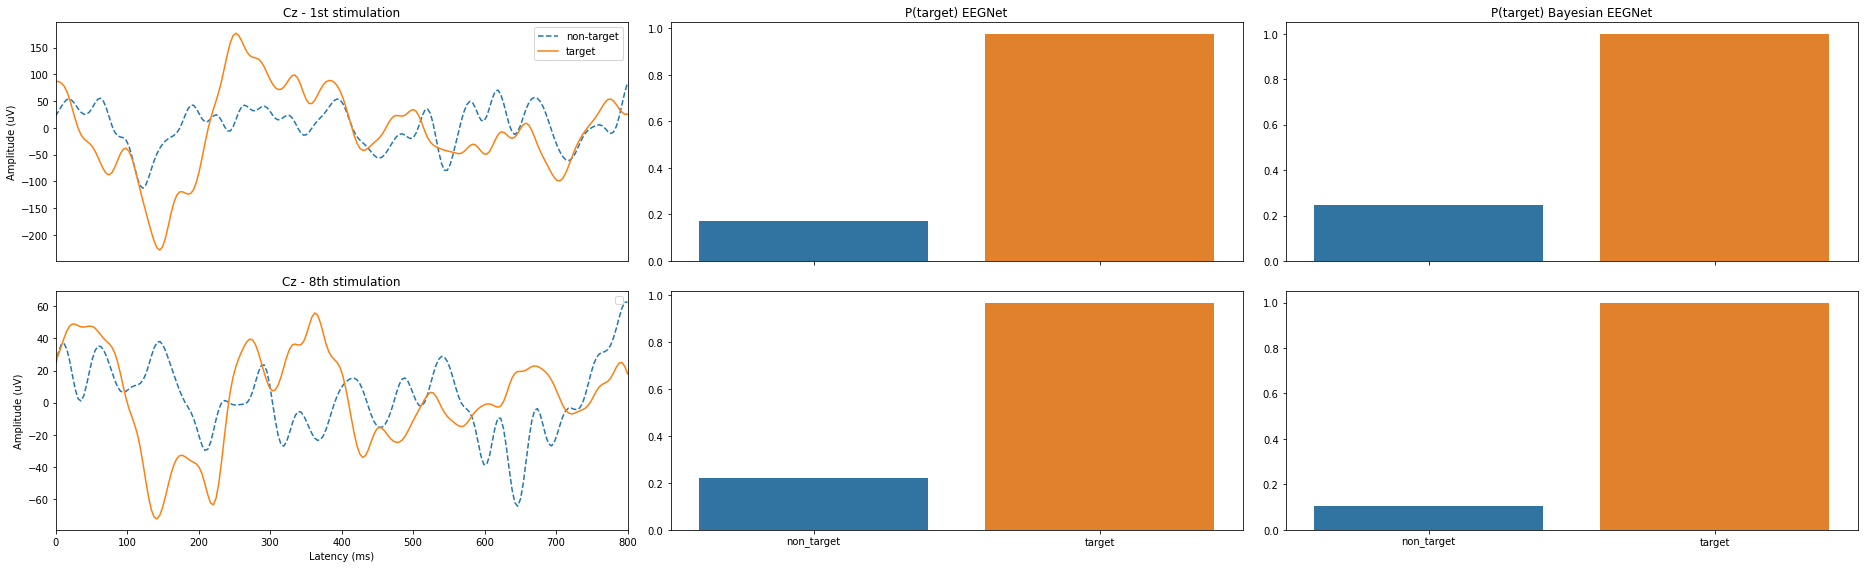

In [63]:
target_pick = 0
non_target_pick = 2


fig, axes = plt.subplots(2, 3, figsize=(26, 8))
xmin, xmax = 0, epoch_length
# ymin, ymax = -125, 125
channel = 'Cz'
channel_idx = meta['channels'].index(channel)


num_mc = 5 # used throughout the notebook

# ensure no array out-of-bound
target_pick %= len(target_idx) 
non_target_pick %= len(non_target_idx)

target_potential_8stim = X_test[[target_idx[target_pick]]]
non_target_potential_8stim = X_test[[non_target_idx[non_target_pick]]]
target_potential_1stim = X_test_1stim[[target_idx[target_pick]]]
non_target_potential_1stim = X_test_1stim[[non_target_idx[non_target_pick]]]


xticks = np.linspace(0, meta['epoch_length'], meta['epoch_length_timepoint'])
sns.lineplot(x=xticks, y=non_target_potential_1stim[:, channel_idx, :, :].squeeze(), label='non-target', linestyle='--', ax=axes[0, 0])
axes[0, 0].set_title(f'{channel} - 1st stimulation')
axes[0, 0].set_xlim(xmin, xmax)
# axes[0, 0].set_ylim(ymin, ymax)
axes[0, 0].set_ylabel('Amplitude (uV)')
sns.lineplot(x=xticks, y=target_potential_1stim[:, channel_idx, :, :].squeeze(), label='target', ax=axes[0, 0])
axes[0, 0].legend(loc='upper right')
axes[0, 0].set_xticks([])

sns.lineplot(x=xticks, y=non_target_potential_8stim[:, channel_idx, :, :].squeeze(), label='non-target', linestyle='--', ax=axes[1, 0])
axes[1, 0].set_xlim(xmin, xmax)
axes[1, 0].set_title(f'{channel} - 8th stimulation')
# axes[1, 0].set_ylim(ymin, ymax)
axes[1, 0].set_ylabel('Amplitude (uV)')
axes[1, 0].set_xlabel('Latency (ms)')
sns.lineplot(x=xticks, y=target_potential_8stim[:, channel_idx, :, :].squeeze(), label='target', ax=axes[1, 0])
axes[1, 0].legend([])

acc_dict = {}
acc_dict['yt1_eegnet'] = eegnet.predict(target_potential_1stim)[0][[1]].tolist()
acc_dict['yt1_bayes'] = np.mean([bayes.predict(target_potential_1stim)[0][1] for i in range(num_mc)])[np.newaxis]
acc_dict['ynt1_eegnet'] = eegnet.predict(non_target_potential_1stim)[0][[1]].tolist()
acc_dict['ynt1_bayes'] = np.mean([bayes.predict(non_target_potential_1stim)[0][1] for i in range(num_mc)])[np.newaxis]
acc_dict['yt8_eegnet'] = eegnet.predict(target_potential_8stim)[0][[1]].tolist()
acc_dict['yt8_bayes'] = np.mean([bayes.predict(target_potential_8stim)[0][1] for i in range(num_mc)])[np.newaxis]
acc_dict['ynt8_eegnet'] = eegnet.predict(non_target_potential_8stim)[0][[1]].tolist()
acc_dict['ynt8_bayes'] = np.mean([bayes.predict(non_target_potential_8stim)[0][1] for i in range(num_mc)])[np.newaxis]
df = pd.DataFrame(acc_dict)

sns.barplot(data=df[['ynt1_eegnet', 'yt1_eegnet']], ax=axes[0, 1])
axes[0, 1].set_title('P(target) EEGNet')
axes[0, 1].set_xticklabels([])

sns.barplot(data=df[['ynt1_bayes', 'yt1_bayes']], ax=axes[0, 2])
axes[0, 2].set_title('P(target) Bayesian EEGNet')
axes[0, 2].set_xticklabels([])

sns.barplot(data=df[['ynt8_eegnet', 'yt8_eegnet']], ax=axes[1, 1])
axes[1, 1].set_xticklabels(['non_target', 'target'])

sns.barplot(data=df[['ynt8_bayes', 'yt8_bayes']], ax=axes[1, 2])
axes[1, 2].set_xticklabels(['non_target', 'target'])
plt.tight_layout()